In [1]:
#System imports
from __future__ import print_function
from __future__ import division
import os
import glob
import json
import collections
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#Extra import
%matplotlib inline
import numpy as np
import SimpleITK as sitk
from joblib import Parallel, delayed
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage.morphology import watershed
import progressbar

In [3]:
datapath = os.path.join(os.path.dirname(os.getcwd()), "BRATS_2016")

In [4]:
impaths = [path for path in glob.glob(os.path.join(datapath, "sourcedata", "*", "*", "*", "*")) if "ce-GADOLINIUM_T1w.nii" in path]
impath = impaths[40]

In [5]:
im = nib.load(impath)
im_arr = im.get_data()
print("Image dimension:", im.shape)
print("Voxel size (mm):", im.header.get_zooms())
sx, sy, sz = im.shape

Image dimension: (240, 240, 155)
Voxel size (mm): (1.0, 1.0, 1.0)


# Segmentation

<font color='red'>Define the Otsu thresholding function</font> 

In [6]:
#Define the Otsu thresholding function 
def otsu(im_arr, mask_arr):
    
    """Otsu thresholding function  
    Inputs:
    im_arr: array,
        the mr image array
    mask_arr: array
        the binary mask array
        
    Outputs:   
    threshold_val: float,
        the threshold value
    """
    
    #...To complete ...
        
    return threshold_val

<font color='red'>Define the maximum entropy thresholding function</font> 

In [7]:
#Define the maximum entropy thresholding function 
def max_entropy(im_arr, mask_arr):

    """Maximum entropy thresholding function 
    Inputs:
    im_arr: array,
        the mr image array
    mask_arr: array
        the binary mask array
        
    Outputs:   
    threshold_val: float,
        the threshold value
    """
    
    #...To complete ...    
    
    return threshold_val

<font color='red'>Compute the brain mask using a 3D Otsu threshold</font> 

In [37]:
#Compute the brain mask using a 3D Otsu thresholding method
thresh_val = otsu(im_arr, np.ones((sx, sy, sz)))
brain_arr = (im_arr >= thresh_val).astype(int)

# Fill the holes in the brain mask 
#You may use the ndimage.binary_fill_holes function
# ... To complete ...  

def show_result(im_arr, seg_arr, mr_slice):
    """ Superimpose the MR slice image and the segmentation contour
    Inputs:
    im_arr: 3D array,
        the mr image array
    seg_arr: 3D array
        the binary segmentation array
    mr_slice: int,
        the MR slice to show
    Outputs:   
    threshold_val: float,
        the threshold value   
    """
    plt.imshow(im_arr[:,:,mr_slice].T, cmap="gray")
    plt.contour(seg_arr[:,:,mr_slice].T, colors="r", linewidths=1, levels=[0.5, 1])
    plt.axis('off')
    plt.pause(0.1)

#Initialize the tumor segmentation with a 3D maximum entropy thresholding
thresh_val = max_entropy(im_arr, brain_arr)
init_seg_arr = (im_arr >= thresh_val).astype(int) 

#Fill the holes in the segmentation array
# ... To complete ...  

#Remove the connected components of volume less than 1000 voxels (26-connectivity)    
# ... To complete ...      

#Show the result        
interactive_plot = interactive(show_result, im_arr=fixed(im_arr), seg_arr=fixed(init_seg_arr), mr_slice=(0, sz, 1))
interactive_plot 

interactive(children=(IntSlider(value=77, description='mr_slice', max=155), Output()), _dom_classes=('widget-i…

The function belows is a simplified implementation of the Watershed algorithm [Beucher, S. and Lantuéjoul, C., 1979].
You may also try more sophisticated implementations from librairies such as Scipy (see http://scipy-lectures.org/advanced/image_processing/auto_examples/plot_watershed_segmentation.html).
For today, let's use the homemade watershed function.

<font color='red'>Read the following code to make sure that you understand the principles behind the watershed algorithm. </font> 

In [61]:
#Home made watershed with markers !
def homemade_watershed(im_arr, mask_arr, markers_arr, se):
    
    """ Watershed segmentation
    Inputs:
    im_arr: 2D or 3D array,
        the mr image array
    mask_arr: 2D or 3D array
        the binary mask array
    markers_arr: 2D or 3D array,
        the labelled marker array 
    se: 3x3 or 3x3x3 array,
        the structuring element defining the connectivity
    Outputs:   
    seg_arr: 2D or 3D array,
        the segmentation array    
    """
        
    #Requantize the image array (not necessary, but reduces computation time)
    #mu = np.mean(im_arr[mask_arr ==1])
    #std = np.std(im_arr[mask_arr ==1])
    #im_arr = (im_arr - mu) / std
    im_arr = 255 * (im_arr - np.min(im_arr[mask_arr == 1])) / (np.max(im_arr[mask_arr == 1]) - np.min(im_arr[mask_arr == 1]))
    im_arr = np.rint(im_arr)

    #Sort the intensity value from lowest to highest value    
    intensity_vals = list(np.unique(im_arr[mask_arr > 0]))
    intensity_vals.sort()
    print("{0} grey levels to process".format(len(intensity_vals)))
          
    seg_arr = np.zeros(im_arr.shape).astype(int)
    with progressbar.ProgressBar(max_value=len(intensity_vals), redirect_stdout=True) as bar:
        for cnt_k, k in enumerate(intensity_vals):

            #print(int(np.round((((cnt_k + 1) / len(intensity_vals)) * 100))))
            #Level set at level k
            kls_arr = np.logical_and(mask_arr > 0, im_arr == k).astype(int)

            #Union between the k level set and the previous segmentation
            kseg_arr = np.logical_or(kls_arr, seg_arr > 0).astype(int)

            #Connected components    
            ccs_arr, nb_ccs = ndimage.label(kseg_arr, structure=se)

            #Get the connected components (cc) including a marker
            ccs_with_markers = np.unique(ccs_arr[markers_arr != 0])
            ccs_with_markers = list(ccs_with_markers[ccs_with_markers != 0])

            #For each cc with markers, check if there is only one marker included
            for cc_id in ccs_with_markers:
                marker_ids = np.unique(markers_arr[ccs_arr == cc_id])
                marker_ids = list(marker_ids[marker_ids != 0])

                #If so, add the whole cc area into the segmentation of the region
                #associated with the marker
                if len(marker_ids) == 1:
                    seg_arr[ccs_arr == cc_id] = marker_ids[0]

            #Update the progress bar  
            bar.update(cnt_k)
            
    return seg_arr        

<font color='red'>Try the homemade watershed algorith on the MR slice number 111 (2D version)
- Choose wisely the image on which the algorithm is applied.
- Use 8-connectivity.    
- Take the labelled minimum extrema as initial markers (use ndimage.label to obtain a labelled image).
- Comment the result.    
</font> 

In [ ]:
#Test the homemade watershed on one MR slice
mr_slice = 111

#Initialization:
markers_arr = #... To complete ...  

se = # ... To complete ...  
seg_arr = # ... To complete ...  

#Get back the tumor segmentation
seg_arr = (seg_arr == 1).astype(int)

#Show the result on the MR slice
plt.imshow(im_arr[:, :, mr_slice].T, cmap="gray")
plt.contour(markers_arr.T, colors="b", linewidths=1, levels=[1.5, 2])
plt.contour(seg_arr.T, colors="r", linewidths=1, levels=[0.5, 1])
plt.axis('off')

<font color='red'>Try the homemade watershed algorith on the MR slice number 111 (2D version)
- Choose wisely the image on which the algorithm is applied.
- Use 8-connectivity.
- Try several p parameters.    
- Comment the result.    
</font> 

100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


125 grey levels to process


(-0.5, 239.5, 239.5, -0.5)

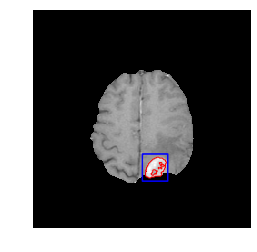

In [66]:
#Test the homemade watershed on one MR slice
mr_slice = 111

#Initialization:
#Intern markers = initial segmentation 
#Extern markers = initial segmentation bounding box + p pixels
p = 5
markers_arr = np.zeros((sx, sy))
[x, y] = np.where(init_seg_arr[:, :, mr_slice] != 0)
bb_arr = np.zeros((sx, sy))
bb_arr[np.min(x) - p:np.max(x) + p, np.min(y) - p:np.max(y) + p] = 1
dist_arr = ndimage.distance_transform_edt(bb_arr).astype(int)
markers_arr[np.logical_and(dist_arr > 0, dist_arr < 1.5)] = 2
markers_arr[init_seg_arr[:, :, mr_slice] == 1] = 1

se = # ... To complete ...  
seg_arr = # ... To complete ...  

#Get back the tumor segmentation
seg_arr = (seg_arr == 1).astype(int)

#Show the result on the MR slice
plt.imshow(im_arr[:, :, mr_slice].T, cmap="gray")
plt.contour(markers_arr.T, colors="b", linewidths=1, levels=[1.5, 2])
plt.contour(seg_arr.T, colors="r", linewidths=1, levels=[0.5, 1])
plt.axis('off')

In [ ]:
<font color='red'>Try the homemade watershed algorith on all the MR slices (2D version)
</font> 

In [75]:
#2D watershed slice by slice

se = # ... To complete ...
seg2d_arr = np.ones((sx, sy, sz))

#Initialization
p = 10
markers_arr = np.zeros((sx, sy, sz))
[x, y, z] = np.where(init_seg_arr != 0)
bb_arr = np.zeros((sx, sy, sz))
bb_arr[np.min(x) - p:np.max(x) + p, np.min(y) - p:np.max(y) + p, np.min(z) - p:np.max(z) + p] = 1
dist_arr = ndimage.distance_transform_edt(bb_arr).astype(int)
markers_arr[np.logical_and(dist_arr > 0, dist_arr < 1.5)] = 2
markers_arr[init_seg_arr == 1] = 1

for mr_slice in range(0, sz):        
        seg2d_arr[:, :, mr_slice] = homemade_watershed #... To complete ...
        
#Restrict the segmentation to the tumor class        
seg2d_arr = (seg2d_arr == 1).astype(int)

#Fill holes
# ... To complete ...

#Show the result        
interactive_plot = interactive(show_result, im_arr=fixed(im_arr), seg_arr=fixed(seg2d_arr), mr_slice=(0, sz, 1))
interactive_plot

100% (87 of 87) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


87 grey levels to process
103 grey levels to process


100% (103 of 103) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 67% (74 of 109) |###############        | Elapsed Time: 0:00:00 ETA:   0:00:00

109 grey levels to process


100% (109 of 109) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (81 of 99) |###################     | Elapsed Time: 0:00:00 ETA:   0:00:00

99 grey levels to process


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 62% (67 of 107) |##############         | Elapsed Time: 0:00:00 ETA:   0:00:00

107 grey levels to process


100% (107 of 107) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 58% (60 of 103) |#############          | Elapsed Time: 0:00:00 ETA:   0:00:00

103 grey levels to process


100% (103 of 103) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (93 of 93) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


93 grey levels to process
113 grey levels to process


100% (113 of 113) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 34% (36 of 103) |########               | Elapsed Time: 0:00:00 ETA:   0:00:00

103 grey levels to process


100% (103 of 103) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (91 of 91) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 101) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

91 grey levels to process
101 grey levels to process


100% (101 of 101) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 56% (55 of 97) |#############           | Elapsed Time: 0:00:00 ETA:   0:00:00

97 grey levels to process


100% (97 of 97) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 59% (55 of 93) |##############          | Elapsed Time: 0:00:00 ETA:   0:00:00

93 grey levels to process


100% (93 of 93) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 51% (49 of 95) |############            | Elapsed Time: 0:00:00 ETA:   0:00:00

95 grey levels to process


100% (95 of 95) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 47% (43 of 91) |###########             | Elapsed Time: 0:00:00 ETA:   0:00:00

91 grey levels to process


100% (91 of 91) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 51% (43 of 83) |############            | Elapsed Time: 0:00:00 ETA:   0:00:00

83 grey levels to process


100% (83 of 83) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 44% (43 of 97) |##########              | Elapsed Time: 0:00:00 ETA:   0:00:00

97 grey levels to process


100% (97 of 97) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 43% (43 of 99) |##########              | Elapsed Time: 0:00:00 ETA:   0:00:00

99 grey levels to process


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 39% (39 of 99) |#########               | Elapsed Time: 0:00:00 ETA:   0:00:00

99 grey levels to process


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 47% (47 of 99) |###########             | Elapsed Time: 0:00:00 ETA:   0:00:00

99 grey levels to process


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 64% (52 of 81) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00

81 grey levels to process


100% (81 of 81) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 69% (63 of 91) |################        | Elapsed Time: 0:00:00 ETA:   0:00:00

91 grey levels to process


100% (91 of 91) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 98% (96 of 97) |####################### | Elapsed Time: 0:00:00 ETA:   0:00:00

97 grey levels to process


100% (97 of 97) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 58% (57 of 97) |##############          | Elapsed Time: 0:00:00 ETA:   0:00:00

97 grey levels to process


100% (97 of 97) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 98% (96 of 97) |####################### | Elapsed Time: 0:00:00 ETA:   0:00:00

97 grey levels to process


100% (97 of 97) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 62% (62 of 99) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00

99 grey levels to process


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (55 of 101) |############           | Elapsed Time: 0:00:00 ETA:   0:00:00

101 grey levels to process


100% (101 of 101) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 67% (67 of 99) |################        | Elapsed Time: 0:00:00 ETA:   0:00:00

99 grey levels to process


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 52% (53 of 101) |############           | Elapsed Time: 0:00:00 ETA:   0:00:00

101 grey levels to process


100% (101 of 101) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 51% (54 of 105) |###########            | Elapsed Time: 0:00:00 ETA:   0:00:00

105 grey levels to process


100% (105 of 105) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 75% (76 of 101) |#################      | Elapsed Time: 0:00:00 ETA:   0:00:00

101 grey levels to process


100% (101 of 101) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 42% (49 of 115) |#########              | Elapsed Time: 0:00:00 ETA:   0:00:00

115 grey levels to process


100% (115 of 115) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 59% (62 of 105) |#############          | Elapsed Time: 0:00:00 ETA:   0:00:00

105 grey levels to process


100% (105 of 105) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 51% (55 of 107) |###########            | Elapsed Time: 0:00:00 ETA:   0:00:00

107 grey levels to process


100% (107 of 107) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 44% (44 of 98) |##########              | Elapsed Time: 0:00:00 ETA:   0:00:00

98 grey levels to process


100% (98 of 98) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 48% (56 of 115) |###########            | Elapsed Time: 0:00:00 ETA:   0:00:00

115 grey levels to process


100% (115 of 115) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 39% (50 of 126) |#########              | Elapsed Time: 0:00:00 ETA:   0:00:00

126 grey levels to process


100% (126 of 126) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 61% (82 of 134) |##############         | Elapsed Time: 0:00:00 ETA:   0:00:00

134 grey levels to process


100% (134 of 134) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 56% (65 of 115) |############           | Elapsed Time: 0:00:00 ETA:   0:00:00

115 grey levels to process


100% (115 of 115) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (90 of 142) |##############         | Elapsed Time: 0:00:00 ETA:   0:00:00

142 grey levels to process


100% (142 of 142) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (125 of 125) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


125 grey levels to process
133 grey levels to process


100% (133 of 133) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 67% (98 of 146) |###############        | Elapsed Time: 0:00:00 ETA:   0:00:00

146 grey levels to process


100% (146 of 146) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 48% (92 of 190) |###########            | Elapsed Time: 0:00:00 ETA:   0:00:00

190 grey levels to process


100% (190 of 190) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


interactive(children=(IntSlider(value=77, description='mr_slice', max=155), Output()), _dom_classes=('widget-i…

<font color='red'>Try the homemade watershed algorith on the whole volume (3D version, 26-connectivity)
</font> 

In [76]:
#Initialization
p = 5
markers_arr = np.zeros((sx, sy, sz))
[x, y, z] = np.where(init_seg_arr != 0)
bb_arr = np.zeros((sx, sy, sz))
bb_arr[np.min(x) - p:np.max(x) + p, np.min(y) - p:np.max(y) + p, np.min(z) - p:np.max(z) + p] = 1
dist_arr = ndimage.distance_transform_edt(bb_arr).astype(int)
markers_arr[np.logical_and(dist_arr > 0, dist_arr < 1.5)] = 2
markers_arr[init_seg_arr == 1] = 1

se = #...To complete ...
seg3d_arr = #...To complete ...

#Restrict the segmentation to the tumor class
seg3d_arr = (seg3d_arr == 1).astype(int)

#Fill holes
#...To complete ...

#Show the result        
interactive_plot = interactive(show_result, im_arr=fixed(im_arr), seg_arr=fixed(seg3d_arr), mr_slice=(0, sz, 1))
interactive_plot

59 grey levels to process


100% (59 of 59) |########################| Elapsed Time: 0:02:22 Time:  0:02:22


interactive(children=(IntSlider(value=77, description='mr_slice', max=155), Output()), _dom_classes=('widget-i…

### Quantitative evaluation

Given AS and MS binary images of the automatic and manual segmentation, the Dice between them is computed as follows:

\begin{equation*}
Dice(AS, MS) = \frac{\left| AS \cap MS \right|}{\left| AS \right| + \left| MS \right|}
\end{equation*}

Dice(AS, MS) = 1 means that there is a full overlap between AS and MS, Dice(AS, MS) = 0 means that there is no overlap betwen these two volumes.

<font color='red'>Compare the Dice between the automatically and manually segmented volume, using a 2D or 3D watershed algorithm. Comment. </font> 

In [ ]:
#...To complete ...

Given $AS_s$ and $MS_s$ the binary images of the surfaces of the automatic and manual segmentation, the Hausdorff distance between them is computed as follows:

\begin{equation*}
\mathrm{HD}(AS_s, MS_s) = \max \left\{ \max d(AS_s, MS_s), \max d(MS_s, AS_s) \right\}
\end{equation*}

<font color='red'>Compare the Hausdorff distances between the automatically and manually segmented volume, using a 2D or 3D watershed algorithm. Comment. </font> 

In [ ]:
#...To complete ...

# Analysis

<font color='red'>Try to predict the grade ! Good luck ! </font> 

In [ ]:
#...To complete ...